In [1]:
import torch
import data
import tqdm
import models
import numpy as np
import json
import rcan
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Loading the configuration file, which contains information about the simulated images, and the telescopes they were modelled on, and some model hyperparameters

In [2]:
with open('../config.json') as config_file:
    config = json.load(config_file)

In [3]:
EPOCHS = 50
LR = 1e-5 
IN_SHAPE = config["image_shape"] # image dimensions in pixels (assuming square image)
MAGNIFICATION = config["magnification"] # magnitude of each magnification
N_MAG = config["n_magnification"] # number of magnifications required to be performed
DELTA = config["resolution"] # LR image resolution
alpha_t_scaling = config["alpha_t_scaling"] # scaling coefficient of the tangential component of the deflection angle 
VDL_WEIGHT = 0.1 # initial vdl weight

### Scaling the deflection angle obtained from the SISR models:
The deflection angle values are obtained by design as $\alpha(x,y) \in (0,1)$. They are thus rescaled within appropriate bounds before their use for the purpose of lensing. The coefficients 1 and 2 correspond to the radial $\alpha_r(x,y)$ and tangential $\alpha_t(x,y)$ components of the deflection angle. While $\alpha_r(x,y)$ can ideally be used to contain all the pertaining information, this is no longer required ot be true, as the image space is discretized to pixels. To account for potential inaccuracies brought by this discretization, a (smaller) $\alpha_t(x,y)$ is used for the purpose of potential correction.

In [ ]:
alpha_bounds = [config["alpha_l"],config["alpha_h"]] # bounds for the deflection angle, used in it's scaling

alpha_coeff_1 = torch.tensor(alpha_bounds[1]-alpha_bounds[0]).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_coeff_2 = torch.tensor((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_coeff = torch.concat([alpha_coeff_1, alpha_coeff_2],dim=1)

alpha_disp_1 = torch.tensor(alpha_bounds[0]).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_disp_2 = torch.tensor(-((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling)/2).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_disp = torch.concat([alpha_disp_1, alpha_disp_2],dim=1)

def alpha_scaling(alpha):
    """
    Scales the deflection angle obtained from the model to meaningful bounds
    
    :param alpha: Deflection angle to be scaled
    :return: Scaled deflection angle
    """
    alpha = alpha * alpha_coeff.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    alpha = alpha + alpha_disp.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    return alpha

### Loading the datasets, the dataloaders and performing the required train:validation partitions
A batch size of 5 (merely for computational convenience) is used 5000 images for training, which is divided by an 80:20 validation split. The 5000 images are derived more-or-less equally from the three DM sub-structure classes. There are no high-resolution images loaded as they are not needed !

In [4]:
# We can now load the datasets, combine and shuffle them to have a (close to) homogenous distribution of all sub-structures.
BATCH_SIZE = 5 # Feel free to increase this number; all the training was done on my personal machine, hence, this limitation/

dataset_no_sub = data.LensingDataset('../../Simulations/data_model_1/',['no_sub'],5000)
train_dataset_no_sub, val_dataset_no_sub = torch.utils.data.random_split(dataset_no_sub, [0.8, 0.2])

dataset_axion = data.LensingDataset('../../Simulations/data_model_1/',['axion'],5000)
train_dataset_axion, val_dataset_axion = torch.utils.data.random_split(dataset_axion, [0.8, 0.2])

dataset_cdm = data.LensingDataset('../../Simulations/data_model_1/',['cdm'],5000)
train_dataset_cdm, val_dataset_cdm = torch.utils.data.random_split(dataset_cdm, [0.8, 0.2])

train_dataset = torch.utils.data.ConcatDataset([train_dataset_no_sub, train_dataset_axion, train_dataset_cdm])
val_dataset = torch.utils.data.ConcatDataset([val_dataset_no_sub, val_dataset_axion, val_dataset_cdm])

train_dataset, train_rest = torch.utils.data.random_split(train_dataset, [0.34, 0.66])
val_dataset, val_rest = torch.utils.data.random_split(val_dataset, [0.34, 0.66])

train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)
val_dataloader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)

# This configuration will load 5000 (low-resolution) images in total, with a 80:20 validation split. 

### Model and physics-inspired loss function loading

In [5]:
# We construct and load the SISR model to the GPU (if available). A loss module is also loaded that performs all the operations required during training.

alpha_model = rcan.RCAN(scale=2, latent_dim=128, num_rg=2, num_rcab=2, reduction=2, out_channels=2).to(device)
lens_loss = models.SersicProfiler(resolution=DELTA, device=device, sersic_args = [1, 1, 0.25], vdl_weight=VDL_WEIGHT)

opt = torch.optim.Adam(params=alpha_model.parameters(),lr=LR)
alpha_params = sum(p.numel() for p in alpha_model.parameters())
print(f"Image network parameters: {alpha_params/1e6}e6 ({900422/1e6}e6 earlier)")

Image network parameters: 2.28365e6 (0.900422e6 earlier)


### Performing weight initialization
Several studies have shown that model weight initialization can help in more effective convergence.

In [6]:
# Performing He initialization of the model weights.

def init_weights(m):
    """
    Iterates through all the convolution and fully connected layers of the model to initialize all their weights

    :param m: Model to be initialized
    """
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)  # He initialization
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

alpha_model.apply(init_weights)

RCAN(
  (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (rgs): Sequential(
    (0): RG(
      (rg): Sequential(
        (0): RCAB(
          (rcab): Sequential(
            (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): ReLU(inplace=True)
            (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (3): ChannelAttention(
              (attention): Sequential(
                (0): AdaptiveAvgPool2d(output_size=1)
                (1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
                (2): ReLU(inplace=True)
                (3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
                (4): Sigmoid()
              )
            )
          )
        )
        (1): RCAB(
          (rcab): Sequential(
            (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): ReLU(inplace=True)
            (2): Conv2d(128, 128, kerne

### Defining functions that sample the model's performance

In [7]:
def give_random_image(dataset, alpha_model, length, i=None, plot=True):
    """
    Provides a random image for evaluation

    :param dataset: Dataset used
    :param alpha_model: Model used
    :param length: Length of dataset used
    :param i: Index of the selected image, default: 
    :param plot: If true, also plots the source fitting graphs
    :return: original LR image, SR image, reconstructed source
    """
    if i == None:
        i = np.random.randint(low=0,high=length)
    LR = dataset[i].view(1,1,IN_SHAPE,IN_SHAPE)
    alpha = alpha_scaling(alpha_model(LR.float().to(device)).detach())
    sersic_profile, LR, source_profile = lens_loss.get_sample(alpha.to(device), LR.to(device), plot)
    LR_im = Image.fromarray(LR.cpu().detach().numpy()[0]*255)
    sersic_im = Image.fromarray(sersic_profile.cpu().detach().numpy()[0]*255)
    source_im = Image.fromarray(source_profile.cpu().detach().numpy()[0]*255)
    return (LR_im, sersic_im, source_im)

def show_random_image(image_tuple):
    """
    Displays the images provided by the give_random_image function
    
    :param image_tuple: Tuple of images returned by the give_random_image function
    """
    LR_im, sersic_im, source_im = image_tuple[0], image_tuple[1], image_tuple[2]
    plot, axes = plt.subplots(1,3)
    plot.set_size_inches(18,6)
    axes[0].imshow(LR_im)
    axes[1].imshow(sersic_im)
    axes[2].imshow(source_im)
    axes[0].set_title("LR_interpolated")
    axes[1].set_title("Image")
    axes[2].set_title("Source Profile")

/home/ashankar/Documents/Work/.env/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


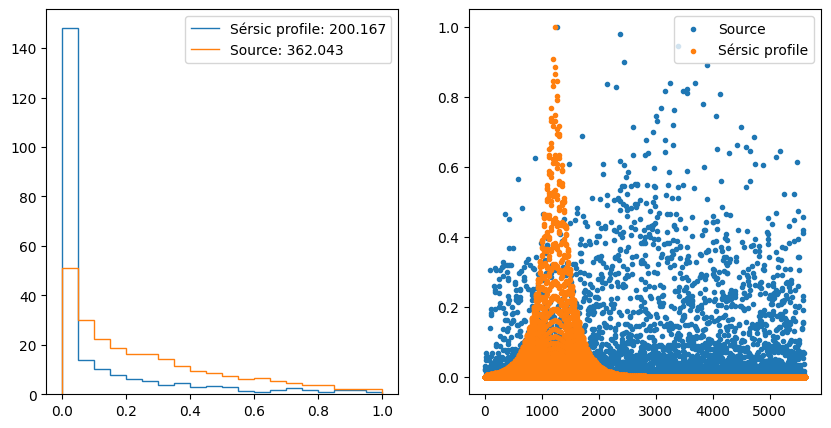

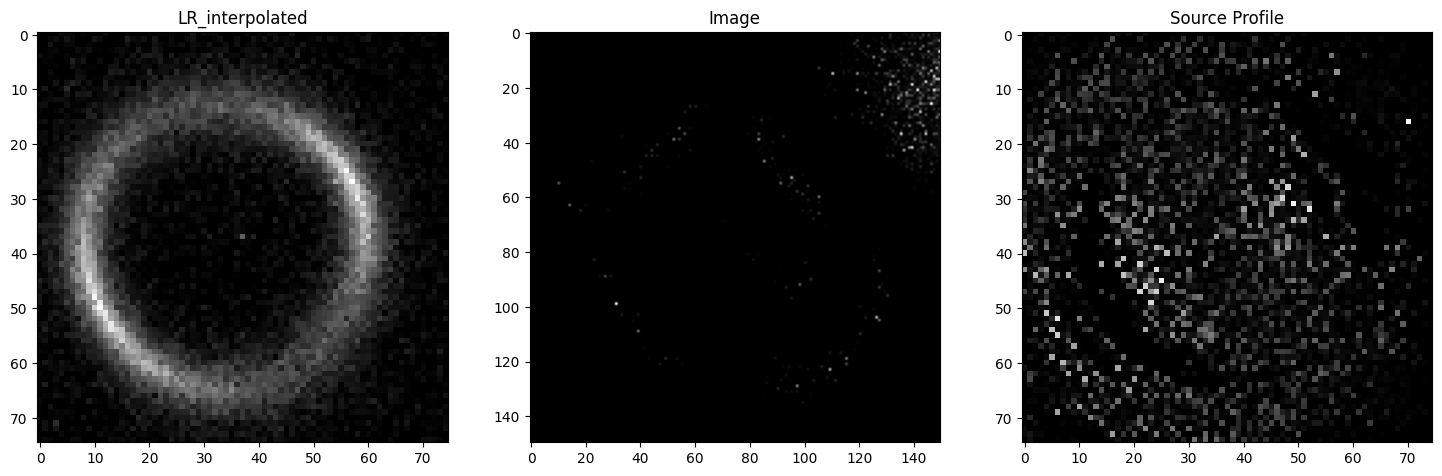

In [8]:
show_random_image(give_random_image(val_dataset, alpha_model, len(val_dataset)))

### The training sequence
The model is trained over the set number of epochs over the training images, and subsequently validated on the validation set. For both, the deflection angle given by the model is used to perform lensing, and is trained in an unsupervised manner by imposing the lensing system's constraints. Since the loss module is composed of various components, each of them is tracked for further study if required. In addition, the training process is stored as GIFs of the SR images, the LR images, and the reconstructed source.

In [9]:
# Training Sequence

best_val_loss = np.inf
best_weights = None
history = {'pre_loss':[],'val_loss':[], 'loss':[], 'images':[], 'lr':[], 'source':[]} # tracks the train and val losses and training results at each epoch
history_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]} # tracks the individual train loss components at each epoch
for epoch in range(EPOCHS):
    losses = []
    alpha_model.train()
    individual_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]}
    for i,(x) in enumerate(tqdm.tqdm(train_dataloader, desc=f"Training epoch {epoch+1}")):
        (x) = (x.float().to(device))
        alpha = alpha_model(x)
        alpha = alpha_scaling(alpha)
        loss, history_individual = lens_loss(alpha, x)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(float(loss))
        for key in individual_losses.keys():
            if history_individual[key] != None:
                individual_losses[key].append(float(history_individual[key]))
            else:
                individual_losses[key].append(None)
    for key in individual_losses.keys():
        if individual_losses[key][-1] != None:
            history_losses[key].append(np.mean(individual_losses[key]))
        else:
            history_losses[key].append(None)
    if np.isnan(losses[-1]): 
        break
    print(f"Training at epoch {epoch+1}/{EPOCHS}: {np.mean(losses) - float(np.mean(individual_losses['alpha_0']))} at LR={opt.param_groups[0]['lr']}")
    history['loss'].append(np.mean(losses) - float(np.mean(individual_losses['alpha_0'])))
    alpha_model.eval()
    individual_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]}
    losses = []
    for i,(x) in enumerate(tqdm.tqdm(val_dataloader, desc=f"Validation epoch {epoch+1}")):
        (x) = (x.float().to(device))
        alpha = alpha_scaling(alpha_model(x))
        val_loss, history_individual = lens_loss(alpha, x)
        losses.append(float(val_loss))
        for key in individual_losses.keys():
            if history_individual[key] != None:
                individual_losses[key].append(float(history_individual[key]))
            else:
                individual_losses[key].append(None)
    if best_val_loss > np.mean(losses):
        best_val_loss = np.mean(losses)
        best_weights = alpha_model.state_dict()
    history['val_loss'].append(np.mean(losses) - float(np.mean(individual_losses['alpha_0'])))
    print(f"Validation at epoch {epoch+1}/{EPOCHS}: {np.mean(losses) - float(np.mean(individual_losses['alpha_0']))} at LR={opt.param_groups[0]['lr']}")
    lr, im, sr = give_random_image(val_dataset, alpha_model, len(val_dataset),50, plot=False)
    history['lr'].append(lr)
    history['images'].append(im)
    history['source'].append(sr)

Training epoch 1: 100%|██████████| 816/816 [01:25<00:00,  9.56it/s]


Training at epoch 1/50: 0.056870888188189195 at LR=1e-05


Validation epoch 1: 100%|██████████| 204/204 [00:08<00:00, 25.23it/s]


Validation at epoch 1/50: 0.05202593040816922 at LR=1e-05


Training epoch 2: 100%|██████████| 816/816 [01:26<00:00,  9.48it/s]


Training at epoch 2/50: 0.05748241444063534 at LR=1e-05


Validation epoch 2: 100%|██████████| 204/204 [00:08<00:00, 25.17it/s]


Validation at epoch 2/50: 0.07143772977824303 at LR=1e-05


Training epoch 3: 100%|██████████| 816/816 [01:26<00:00,  9.44it/s]


Training at epoch 3/50: 0.06400821045698488 at LR=1e-05


Validation epoch 3: 100%|██████████| 204/204 [00:08<00:00, 25.00it/s]


Validation at epoch 3/50: 0.05425992761464679 at LR=1e-05


Training epoch 4: 100%|██████████| 816/816 [01:26<00:00,  9.40it/s]


Training at epoch 4/50: 0.05412370596519289 at LR=1e-05


Validation epoch 4: 100%|██████████| 204/204 [00:08<00:00, 24.65it/s]


Validation at epoch 4/50: 0.05432319075015246 at LR=1e-05


Training epoch 5: 100%|██████████| 816/816 [01:26<00:00,  9.40it/s]


Training at epoch 5/50: 0.05169348608629376 at LR=1e-05


Validation epoch 5: 100%|██████████| 204/204 [00:08<00:00, 24.85it/s]


Validation at epoch 5/50: 0.05038255858508979 at LR=1e-05


Training epoch 6: 100%|██████████| 816/816 [01:27<00:00,  9.36it/s]


Training at epoch 6/50: 0.05044520585615116 at LR=1e-05


Validation epoch 6: 100%|██████████| 204/204 [00:08<00:00, 24.93it/s]


Validation at epoch 6/50: 0.05103812512813831 at LR=1e-05


Training epoch 7: 100%|██████████| 816/816 [01:27<00:00,  9.35it/s]


Training at epoch 7/50: 0.05000234975516066 at LR=1e-05


Validation epoch 7: 100%|██████████| 204/204 [00:08<00:00, 24.79it/s]


Validation at epoch 7/50: 0.050603051195103756 at LR=1e-05


Training epoch 8: 100%|██████████| 816/816 [01:27<00:00,  9.35it/s]


Training at epoch 8/50: 0.051035748717064656 at LR=1e-05


Validation epoch 8: 100%|██████████| 204/204 [00:08<00:00, 24.78it/s]


Validation at epoch 8/50: 0.050554721926649414 at LR=1e-05


Training epoch 9: 100%|██████████| 816/816 [01:27<00:00,  9.35it/s]


Training at epoch 9/50: 0.05057430105265595 at LR=1e-05


Validation epoch 9: 100%|██████████| 204/204 [00:08<00:00, 24.55it/s]


Validation at epoch 9/50: 0.050968068651855 at LR=1e-05


Training epoch 10: 100%|██████████| 816/816 [01:27<00:00,  9.34it/s]


Training at epoch 10/50: 0.05102082818983963 at LR=1e-05


Validation epoch 10: 100%|██████████| 204/204 [00:08<00:00, 24.52it/s]


Validation at epoch 10/50: 0.053072554643685904 at LR=1e-05


Training epoch 11: 100%|██████████| 816/816 [01:27<00:00,  9.31it/s]


Training at epoch 11/50: 0.05031398730809052 at LR=1e-05


Validation epoch 11: 100%|██████████| 204/204 [00:08<00:00, 24.69it/s]


Validation at epoch 11/50: 0.05460704512455885 at LR=1e-05


Training epoch 12: 100%|██████████| 816/816 [01:27<00:00,  9.33it/s]


Training at epoch 12/50: 0.0507420451613143 at LR=1e-05


Validation epoch 12: 100%|██████████| 204/204 [00:08<00:00, 24.78it/s]


Validation at epoch 12/50: 0.05179447300878225 at LR=1e-05


Training epoch 13: 100%|██████████| 816/816 [01:27<00:00,  9.33it/s]


Training at epoch 13/50: 0.05003205428183005 at LR=1e-05


Validation epoch 13: 100%|██████████| 204/204 [00:08<00:00, 24.85it/s]


Validation at epoch 13/50: 0.04991219091393492 at LR=1e-05


Training epoch 14: 100%|██████████| 816/816 [01:27<00:00,  9.33it/s]


Training at epoch 14/50: 0.04938065997032705 at LR=1e-05


Validation epoch 14: 100%|██████████| 204/204 [00:08<00:00, 24.79it/s]


Validation at epoch 14/50: 0.050689856046993366 at LR=1e-05


Training epoch 15: 100%|██████████| 816/816 [01:27<00:00,  9.33it/s]


Training at epoch 15/50: 0.05031225803152968 at LR=1e-05


Validation epoch 15: 100%|██████████| 204/204 [00:08<00:00, 24.86it/s]


Validation at epoch 15/50: 0.050419830251485116 at LR=1e-05


Training epoch 16: 100%|██████████| 816/816 [01:27<00:00,  9.31it/s]


Training at epoch 16/50: 0.05041836651599071 at LR=1e-05


Validation epoch 16: 100%|██████████| 204/204 [00:08<00:00, 24.53it/s]


Validation at epoch 16/50: 0.05155594407708622 at LR=1e-05


Training epoch 17: 100%|██████████| 816/816 [01:27<00:00,  9.33it/s]


Training at epoch 17/50: 0.05088564900991817 at LR=1e-05


Validation epoch 17: 100%|██████████| 204/204 [00:08<00:00, 24.74it/s]


Validation at epoch 17/50: 0.05084048785890142 at LR=1e-05


Training epoch 18: 100%|██████████| 816/816 [01:27<00:00,  9.30it/s]


Training at epoch 18/50: 0.0507844495975102 at LR=1e-05


Validation epoch 18: 100%|██████████| 204/204 [00:08<00:00, 24.68it/s]


Validation at epoch 18/50: 0.051718085748600026 at LR=1e-05


Training epoch 19: 100%|██████████| 816/816 [01:27<00:00,  9.30it/s]


Training at epoch 19/50: 0.051407825213163075 at LR=1e-05


Validation epoch 19: 100%|██████████| 204/204 [00:08<00:00, 24.65it/s]


Validation at epoch 19/50: 0.052934298556590195 at LR=1e-05


Training epoch 20: 100%|██████████| 816/816 [01:27<00:00,  9.31it/s]


Training at epoch 20/50: 0.050800104148448544 at LR=1e-05


Validation epoch 20: 100%|██████████| 204/204 [00:08<00:00, 24.73it/s]


Validation at epoch 20/50: 0.051612500475683054 at LR=1e-05


Training epoch 21: 100%|██████████| 816/816 [01:27<00:00,  9.30it/s]


Training at epoch 21/50: 0.050575575038023735 at LR=1e-05


Validation epoch 21: 100%|██████████| 204/204 [00:08<00:00, 24.59it/s]


Validation at epoch 21/50: 0.04988284405393928 at LR=1e-05


Training epoch 22: 100%|██████████| 816/816 [01:27<00:00,  9.30it/s]


Training at epoch 22/50: 0.0499323576770942 at LR=1e-05


Validation epoch 22: 100%|██████████| 204/204 [00:08<00:00, 24.52it/s]


Validation at epoch 22/50: 0.04977841629628457 at LR=1e-05


Training epoch 23: 100%|██████████| 816/816 [01:27<00:00,  9.30it/s]


Training at epoch 23/50: 0.05038788299163001 at LR=1e-05


Validation epoch 23: 100%|██████████| 204/204 [00:08<00:00, 24.71it/s]


Validation at epoch 23/50: 0.05057514982535412 at LR=1e-05


Training epoch 24: 100%|██████████| 816/816 [01:27<00:00,  9.29it/s]


Training at epoch 24/50: 0.04968009921539502 at LR=1e-05


Validation epoch 24: 100%|██████████| 204/204 [00:08<00:00, 24.65it/s]


Validation at epoch 24/50: 0.05042871028440548 at LR=1e-05


Training epoch 25: 100%|██████████| 816/816 [01:27<00:00,  9.31it/s]


Training at epoch 25/50: 0.049458623239450966 at LR=1e-05


Validation epoch 25: 100%|██████████| 204/204 [00:08<00:00, 24.74it/s]


Validation at epoch 25/50: 0.049770808847182824 at LR=1e-05


Training epoch 26: 100%|██████████| 816/816 [01:28<00:00,  9.27it/s]


Training at epoch 26/50: 0.049089881076760516 at LR=1e-05


Validation epoch 26: 100%|██████████| 204/204 [00:08<00:00, 24.60it/s]


Validation at epoch 26/50: 0.049036614455319205 at LR=1e-05


Training epoch 27: 100%|██████████| 816/816 [01:27<00:00,  9.32it/s]


Training at epoch 27/50: 0.04929094781469115 at LR=1e-05


Validation epoch 27: 100%|██████████| 204/204 [00:08<00:00, 24.65it/s]


Validation at epoch 27/50: 0.04968921776276593 at LR=1e-05


Training epoch 28: 100%|██████████| 816/816 [01:27<00:00,  9.29it/s]


Training at epoch 28/50: 0.0492732091978028 at LR=1e-05


Validation epoch 28: 100%|██████████| 204/204 [00:08<00:00, 24.27it/s]


Validation at epoch 28/50: 0.04871815361776481 at LR=1e-05


Training epoch 29: 100%|██████████| 816/816 [01:27<00:00,  9.30it/s]


Training at epoch 29/50: 0.049010697646093934 at LR=1e-05


Validation epoch 29: 100%|██████████| 204/204 [00:08<00:00, 24.60it/s]


Validation at epoch 29/50: 0.04982520043667333 at LR=1e-05


Training epoch 30: 100%|██████████| 816/816 [01:27<00:00,  9.29it/s]


Training at epoch 30/50: 0.049830493007046985 at LR=1e-05


Validation epoch 30: 100%|██████████| 204/204 [00:08<00:00, 24.76it/s]


Validation at epoch 30/50: 0.04946205207128442 at LR=1e-05


Training epoch 31: 100%|██████████| 816/816 [01:27<00:00,  9.30it/s]


Training at epoch 31/50: 0.04913094951132056 at LR=1e-05


Validation epoch 31: 100%|██████████| 204/204 [00:08<00:00, 24.62it/s]


Validation at epoch 31/50: 0.04897005572988122 at LR=1e-05


Training epoch 32: 100%|██████████| 816/816 [01:27<00:00,  9.31it/s]


Training at epoch 32/50: 0.04833076732557304 at LR=1e-05


Validation epoch 32: 100%|██████████| 204/204 [00:08<00:00, 24.56it/s]


Validation at epoch 32/50: 0.04881818994295363 at LR=1e-05


Training epoch 33: 100%|██████████| 816/816 [01:27<00:00,  9.30it/s]


Training at epoch 33/50: 0.048477505740033934 at LR=1e-05


Validation epoch 33: 100%|██████████| 204/204 [00:08<00:00, 24.46it/s]


Validation at epoch 33/50: 0.04935141498515126 at LR=1e-05


Training epoch 34: 100%|██████████| 816/816 [01:27<00:00,  9.29it/s]


Training at epoch 34/50: 0.048576696193777025 at LR=1e-05


Validation epoch 34: 100%|██████████| 204/204 [00:08<00:00, 24.58it/s]


Validation at epoch 34/50: 0.048930921623775485 at LR=1e-05


Training epoch 35: 100%|██████████| 816/816 [01:27<00:00,  9.31it/s]


Training at epoch 35/50: 0.04864320184295887 at LR=1e-05


Validation epoch 35: 100%|██████████| 204/204 [00:08<00:00, 24.78it/s]


Validation at epoch 35/50: 0.048920808410198954 at LR=1e-05


Training epoch 36: 100%|██████████| 816/816 [01:27<00:00,  9.30it/s]


Training at epoch 36/50: 0.04833532826103014 at LR=1e-05


Validation epoch 36: 100%|██████████| 204/204 [00:08<00:00, 24.44it/s]


Validation at epoch 36/50: 0.049407926940487 at LR=1e-05


Training epoch 37: 100%|██████████| 816/816 [01:27<00:00,  9.29it/s]


Training at epoch 37/50: 0.0478042373856 at LR=1e-05


Validation epoch 37: 100%|██████████| 204/204 [00:08<00:00, 24.98it/s]


Validation at epoch 37/50: 0.04862508344390959 at LR=1e-05


Training epoch 38: 100%|██████████| 816/816 [01:27<00:00,  9.29it/s]


Training at epoch 38/50: 0.047383909462951124 at LR=1e-05


Validation epoch 38: 100%|██████████| 204/204 [00:08<00:00, 24.86it/s]


Validation at epoch 38/50: 0.04822038028243125 at LR=1e-05


Training epoch 39: 100%|██████████| 816/816 [01:27<00:00,  9.30it/s]


Training at epoch 39/50: 0.04674074967168089 at LR=1e-05


Validation epoch 39: 100%|██████████| 204/204 [00:08<00:00, 24.48it/s]


Validation at epoch 39/50: 0.046593215147617696 at LR=1e-05


Training epoch 40: 100%|██████████| 816/816 [01:27<00:00,  9.29it/s]


Training at epoch 40/50: 0.04755827589029008 at LR=1e-05


Validation epoch 40: 100%|██████████| 204/204 [00:08<00:00, 24.80it/s]


Validation at epoch 40/50: 0.04760249467183124 at LR=1e-05


Training epoch 41: 100%|██████████| 816/816 [01:27<00:00,  9.30it/s]


Training at epoch 41/50: 0.03831577960027418 at LR=1e-05


Validation epoch 41: 100%|██████████| 204/204 [00:08<00:00, 24.72it/s]


Validation at epoch 41/50: 0.010396814106178341 at LR=1e-05


Training epoch 42: 100%|██████████| 816/816 [01:27<00:00,  9.30it/s]


Training at epoch 42/50: 0.007030398046196092 at LR=1e-05


Validation epoch 42: 100%|██████████| 204/204 [00:08<00:00, 24.47it/s]


Validation at epoch 42/50: 0.00901519117292528 at LR=1e-05


Training epoch 43: 100%|██████████| 816/816 [01:27<00:00,  9.30it/s]


Training at epoch 43/50: 0.005884884005211586 at LR=1e-05


Validation epoch 43: 100%|██████████| 204/204 [00:08<00:00, 24.58it/s]


Validation at epoch 43/50: 0.005647231705998089 at LR=1e-05


Training epoch 44: 100%|██████████| 816/816 [01:27<00:00,  9.31it/s]


Training at epoch 44/50: 0.005846879580263596 at LR=1e-05


Validation epoch 44: 100%|██████████| 204/204 [00:08<00:00, 24.63it/s]


Validation at epoch 44/50: 0.007473878030592174 at LR=1e-05


Training epoch 45: 100%|██████████| 816/816 [01:27<00:00,  9.30it/s]


Training at epoch 45/50: 0.006258017309900263 at LR=1e-05


Validation epoch 45: 100%|██████████| 204/204 [00:08<00:00, 24.62it/s]


Validation at epoch 45/50: 0.007508610569251081 at LR=1e-05


Training epoch 46: 100%|██████████| 816/816 [01:27<00:00,  9.29it/s]


Training at epoch 46/50: 0.0062737572697383875 at LR=1e-05


Validation epoch 46: 100%|██████████| 204/204 [00:08<00:00, 24.71it/s]


Validation at epoch 46/50: 0.007206630438803603 at LR=1e-05


Training epoch 47: 100%|██████████| 816/816 [01:27<00:00,  9.29it/s]


Training at epoch 47/50: 0.0063979583427163905 at LR=1e-05


Validation epoch 47: 100%|██████████| 204/204 [00:08<00:00, 24.78it/s]


Validation at epoch 47/50: 0.005902320167104549 at LR=1e-05


Training epoch 48: 100%|██████████| 816/816 [01:27<00:00,  9.29it/s]


Training at epoch 48/50: 0.00626676879006018 at LR=1e-05


Validation epoch 48: 100%|██████████| 204/204 [00:08<00:00, 24.51it/s]


Validation at epoch 48/50: 0.005956631708506715 at LR=1e-05


Training epoch 49: 100%|██████████| 816/816 [01:27<00:00,  9.30it/s]


Training at epoch 49/50: 0.006285118598230732 at LR=1e-05


Validation epoch 49: 100%|██████████| 204/204 [00:08<00:00, 24.86it/s]


Validation at epoch 49/50: 0.0070754712305999565 at LR=1e-05


Training epoch 50: 100%|██████████| 816/816 [01:27<00:00,  9.31it/s]


Training at epoch 50/50: 0.006347042716144785 at LR=1e-05


Validation epoch 50: 100%|██████████| 204/204 [00:08<00:00, 24.67it/s]

Validation at epoch 50/50: 0.005812191660059434 at LR=1e-05


Text(0.5, 1.0, 'Individual losses plot')

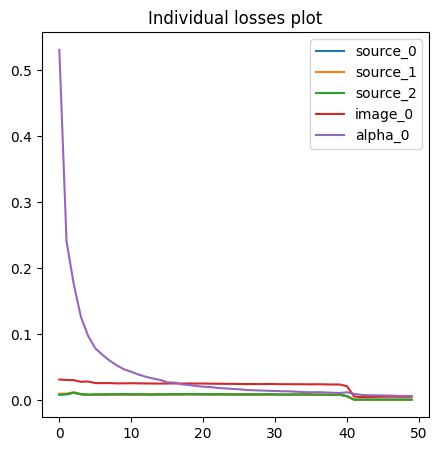

In [10]:
plot, axes = plt.subplots(1,1)
plot.set_size_inches(5,5)
for key in list(individual_losses.keys()):
    axes.plot(history_losses[key],label=key)
axes.legend()
axes.set_title('Individual losses plot')

Text(0.5, 1.0, 'Train and val losses')

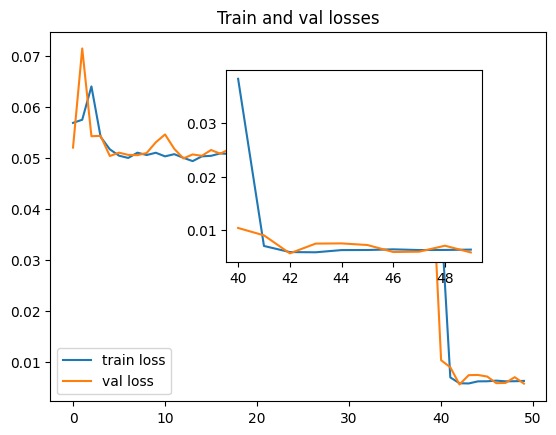

In [11]:
plot, axes = plt.subplots()
axes.plot(history['loss'],label='train loss')
axes.plot(history['val_loss'],label='val loss')
axes_2 = plot.add_axes([0.4,0.4,0.4,0.4])
axes_2.plot(range(int(0.8*EPOCHS),EPOCHS),history['loss'][int(0.8*EPOCHS):],label='train loss')
axes_2.plot(range(int(0.8*EPOCHS),EPOCHS),history['val_loss'][int(0.8*EPOCHS):],label='val loss')
# axes_2.set_xticks([int(0.8*EPOCHS), EPOCHS])
axes.legend(loc='lower left')
axes.set_title('Train and val losses')

### Loading the best performing model

In [12]:
# Loads the model weights at the lowest validation score

alpha_model.load_state_dict(best_weights)
print(best_val_loss)

0.01117545828752804


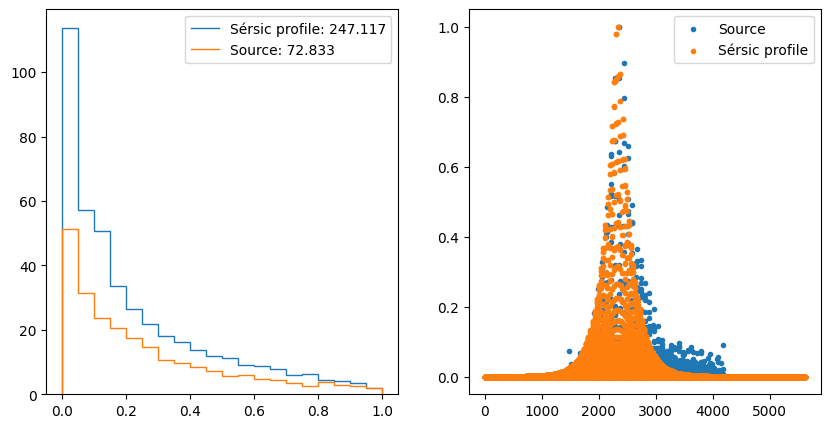

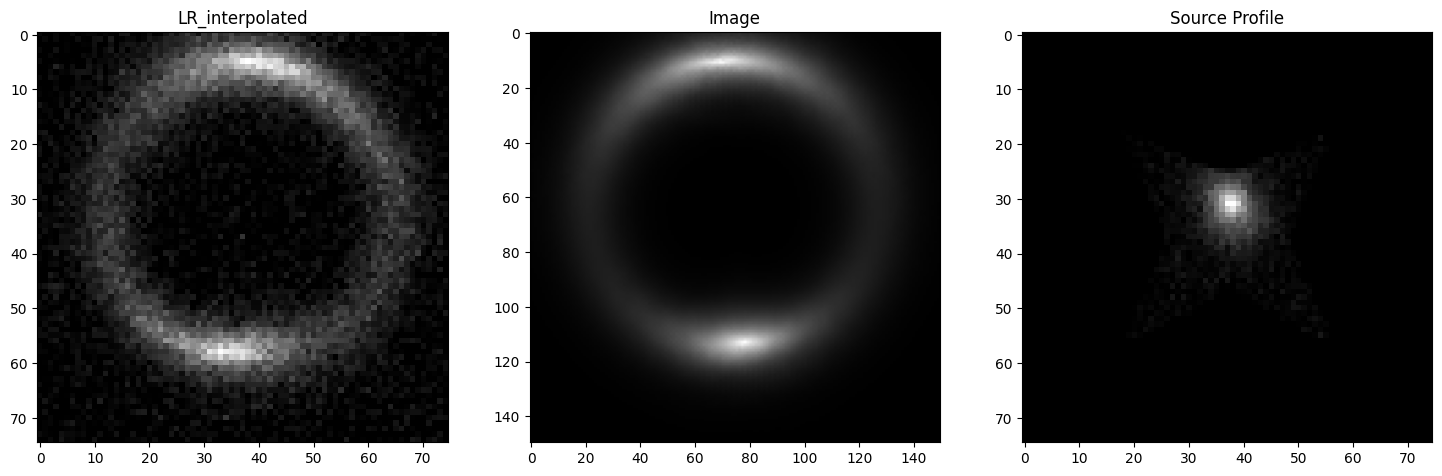

In [13]:
show_random_image(give_random_image(val_dataset, alpha_model, len(val_dataset)))

In [14]:
# Saves the training progress as GIFs of the reconstructed source and the super-resolved images

history['images'][0].save('images.gif',save_all=True, append_images = history['images'][1:], optimize=False, duration=100, loop=0)
history['lr'][0].save('lr.gif',save_all=True, append_images = history['lr'][1:], optimize=False, duration=100, loop=0)
history['source'][0].save('source.gif',save_all=True, append_images = history['source'][1:], optimize=False, duration=100, loop=0)

In [15]:
torch.save(best_weights, 'Weights_1.pt')